# Custom Dataset 

Custom dataset is a collection of data relating to a specific problem you're working on 


## Import


In [1]:
import torch
import torchvision
import torchmetrics 
import requests
import matplotlib.pyplot as plt 
import numpy 
import zipfile


from pathlib import Path
from torch import nn 



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## Get our dataset 

In [3]:
def download_and_extract_zip(url: str, download_dir: Path, zip_filename: str, extract_to: str):
    """
    Downloads a ZIP file from the given URL and extracts it.

    Args:
        url (str): URL to the ZIP file.
        download_dir (Path): Path object where ZIP file will be saved and data extracted.
        zip_filename (str): Name of the ZIP file to save.
        extract_to (str): Name of the directory to extract contents into (relative to download_dir).
    """
    download_dir.mkdir(parents=True, exist_ok=True)

    zip_path = download_dir / zip_filename
    extract_path = download_dir / extract_to

    print(f"Downloading ZIP file from {url}...")
    response = requests.get(url)
    zip_path.write_bytes(response.content)

    print(f"Extracting to {extract_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(path=extract_path)
    
    try:
        zip_path.unlink()
        print("ZIP file deleted.")
    except Exception as e:
        print(f"Failed to delete ZIP file: {e}")

    print("Download and extraction complete.")





In [4]:
URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip"
PATH = Path("../Data")
ZIP = "custom_data.zip"
IMAGE = "piza_sushi"

download_and_extract_zip(URL, PATH, ZIP, IMAGE)


Extracting to ../Data/piza_sushi...
ZIP file deleted.
Download and extraction complete.


## Preparing the dataset

In [5]:
!nvidia-smi


Sun May 25 16:46:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Our dataset is a subset of [food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) this dataset    
has 101 different classes and there are 750 images per class 

We will be using a subset of this dataset with 3 class with 10% of the data 



## Becoming one with the data 

In [6]:
import os 
def walk_dir(dir_path:Path):
    """Give a info about the dir """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


In [7]:
dir_path = Path('../Data/piza_sushi')
walk_dir(dir_path)


There are 2 directories and 0 images in '../Data/piza_sushi'
There are 3 directories and 0 images in '../Data/piza_sushi/test'
There are 0 directories and 46 images in '../Data/piza_sushi/test/sushi'
There are 0 directories and 58 images in '../Data/piza_sushi/test/steak'
There are 0 directories and 46 images in '../Data/piza_sushi/test/pizza'
There are 3 directories and 0 images in '../Data/piza_sushi/train'
There are 0 directories and 150 images in '../Data/piza_sushi/train/sushi'
There are 0 directories and 146 images in '../Data/piza_sushi/train/steak'
There are 0 directories and 154 images in '../Data/piza_sushi/train/pizza'


Image path: ../Data/piza_sushi/test/sushi/3834718.jpg
Image class: sushi
Image width: 512
Image height: 512


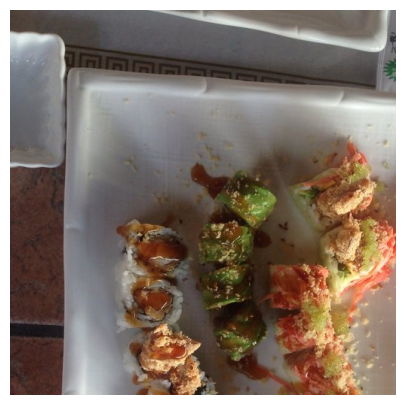

In [8]:
# visualizing image 

# get all of the image path 
# get a random path of the image using random.choice
# get the image class name using pathlib.path.parent.stem
# Open the image using PIL - python.pillow 
# show the image and print some metadata

import random 
from PIL import Image

# random.seed(42)

image_path = Path('../Data/piza_sushi')

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)


image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")

plt.figure(figsize=(10, 5))
plt.axis(False)
plt.imshow(img);


## Transforming Data

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [10]:
data_transform = transforms.Compose([
    # resize the all the image into same height and width 
    transforms.Resize((64, 64)),

    # flip some of the images 
    transforms.RandomHorizontalFlip(p=0.5),

    # Turn the image into a tensor
    transforms.ToTensor()

])


In [11]:
test_transformed_image = data_transform(img)
test_transformed_image.shape


torch.Size([3, 64, 64])

In [12]:
# A function to show transformed image alongside original image 

def plot_transformed_images(image_path:Path, transforms:torchvision.transforms, n=3, seed=42 ):
    random.seed(seed)
    random_image_paths = random.sample(image_path, k=3)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transforms(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)




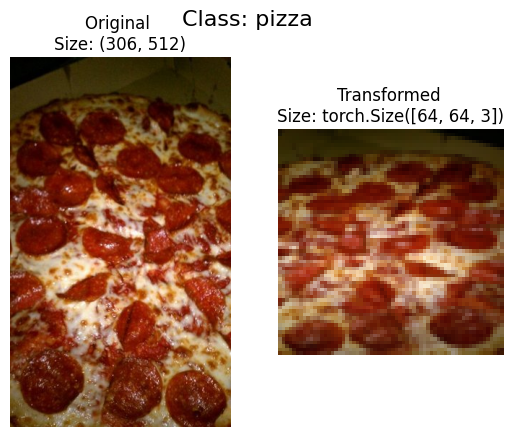

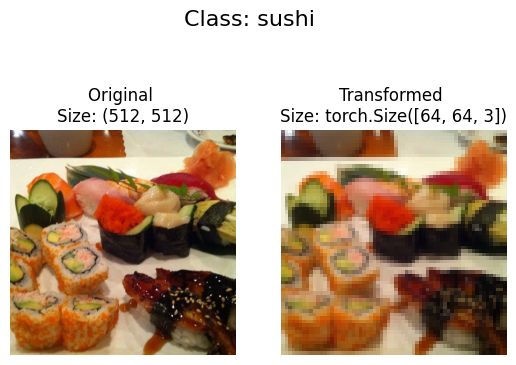

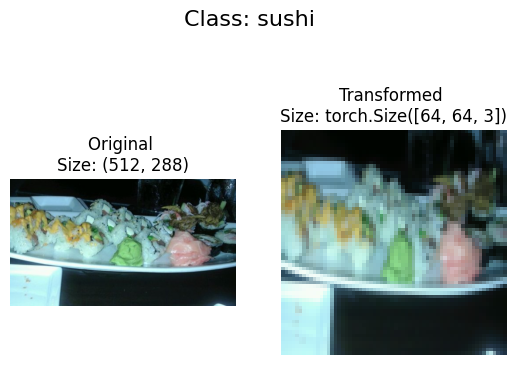

In [13]:
plot_transformed_images(image_path_list, data_transform)


## Loading Image Data using ImageFolder


In [14]:
# since our data is in standard image classification format, we ca use the class torchvision.datasets.ImageFolder

train_dir = Path('../Data/piza_sushi/train')
test_dir = Path('../Data/piza_sushi/test')

train_data = datasets.ImageFolder(
    root=train_dir,
    transform = data_transform, 
    target_transform= None
)

test_data = datasets.ImageFolder(
    root=test_dir, 
    transform = data_transform, 
    target_transform= None
)

print(f"Train directory : {train_dir}")
print(f'Train data: {train_data}')
print(f"Test dir: {test_dir}")
print(f"Test data : {test_data}")


Train directory : ../Data/piza_sushi/train
Train data: Dataset ImageFolder
    Number of datapoints: 450
    Root location: ../Data/piza_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test dir: ../Data/piza_sushi/test
Test data : Dataset ImageFolder
    Number of datapoints: 150
    Root location: ../Data/piza_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [15]:
# we have registered our dataset using pytorch 

class_names = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Classes: {class_names}, Classes with idx: {class_to_idx}")
print(f"{len(train_data), len(test_data)}")


Classes: ['pizza', 'steak', 'sushi'], Classes with idx: {'pizza': 0, 'steak': 1, 'sushi': 2}
(450, 150)


In [16]:
img , label = train_data[0][0] , train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")



Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Text(0.5, 1.0, 'pizza')

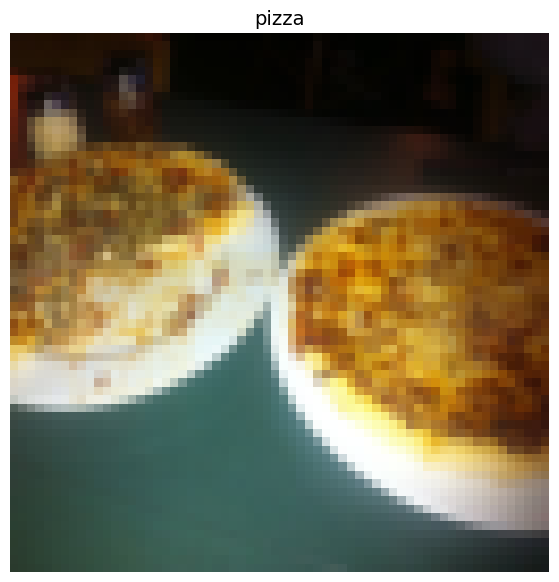

In [17]:
img_premute = img.permute(1,2,0)

plt.figure(figsize=(10, 7))
plt.imshow(img_premute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)


We can see a the image is now more pixelated (less quality) - this is due to it being resized from `512X512` to `64X64`

In [18]:
import os 

os.cpu_count()


8

num_workers in DataLoader - it defines how many subprocesses will be created to load your data. 



In [22]:
# Turing the loaded dataset to dataloader 

BATCH_SIZE = 1
NUM_WORKER = 8 

train_dataloader = DataLoader(
    dataset = train_data, 
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKER,
    shuffle= True, 
    drop_last = True
)


test_dataloader = DataLoader(
    dataset = test_data, 
    batch_size = BATCH_SIZE, 
    num_workers= NUM_WORKER, 
    shuffle= True, 
    drop_last=True
)


train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7fc615b6b130>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc615b6b2b0>)

In [23]:
img, label = next(iter(train_dataloader))
print(f'Image shape: {img.shape}')
print(f'Label shape: {label.shape}')


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## Loading Image Data with a custom dataset

Building our own dataset class using `torchvision.datasets.ImageFolder()`

Pros and cons of creating our own custom way to load Dataset's

We will be using: 

* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom Dataset.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.


In [21]:
import os 
import torch 
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List



### Creating a helper function to get class names 

In [26]:
train_data.classes, train_data.class_to_idx

# we will create a helper function to get similar result for our custom_dataset class 


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [34]:
# get the class name to traverse a target directory 
# raise an error if the class names aren't found - this means error in the directory structure 
# turn the class names into a dictionary of numerical labels for each class

target_dir = train_dir
print(f'Target directory: {train_dir}')

class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
print(class_names_found)
class_names_found_dict = {v:k for k, v in enumerate(class_names_found)}

class_names_found_dict


Target directory: ../Data/piza_sushi/train
['pizza', 'steak', 'sushi']


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
def find_classes(directory:str) -> Tuple[List[str] , Dict[str, int]]:
    """Finds the class folder name in a target directory. 
    
    Assumes target directory is in standard image classification format.
    
    Args: 
        directory (str): target directory to load class names form. 
    
    Returns: 
        Tuple[List[str]], Dict[str, int]: (list_of_class_names, dict(class_names: index))
    
    Examples: 
        find_classes('food/train')
        >>> (['class_1', 'class_2'], {"class_1: 0, ...})
    """
    
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    return classes, class_to_idx


In [42]:
classes = find_classes(target_dir)
classes[0], classes[1]


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom dataset to replicate ImageDataset


1. We want to get the labels, labels_to_idx 
2. We want to transform our data 
3. We want to load all the image in our targ_dir
4. overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the dataset this is recommended but not required.
5. overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required 

In [64]:
class ImageDatasetCustom(Dataset):
    def __init__(self, targ_dir:str, transform=None) -> None:
        self.__paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # Assuming we have a standard image folder structure for classification 
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    
    def load_image(self, index: int)-> Image.Image:
        image_path = self.__paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.__paths)

    def __getitem__(self, index:int)-> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.__paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx 
        else: 
            return img, class_idx


In [65]:
train_data_custom = ImageDatasetCustom(
    targ_dir = '../Data/piza_sushi/train',
    transform= data_transform
)

train_data_custom


In [66]:
len(train_data_custom)


450

In [70]:
train_data_custom.classes, train_data_custom.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### A function to display random images


In [92]:
# Take image from the dataset 10 max and plot them
# these 10 images are random 

def display_random_images(dataset:Dataset, class_names:List[str], n=10, seed=None , display_shape:bool=True):
    if seed: 
        random.seed(seed)
    
    if n > 10: 
        n = 10
        display_shape = False
        print(f"For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display")
    
    
    random_sample_idx = random.sample(range(len(dataset)), k = n)
    
    plt.figure(figsize=(16, 8))
    
    for i , targ_sample in enumerate(random_sample_idx):
        trag_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        targ_image_adjust = trag_image.permute(1, 2,0)
        
        plt.subplot(1,n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if class_names: 
            title = f"claas: {class_names[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)
        
        
        
    


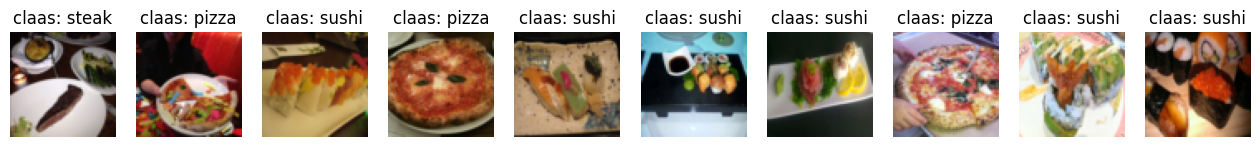

In [94]:
display_random_images(train_data, classes[0] , n = 10, display_shape=False )


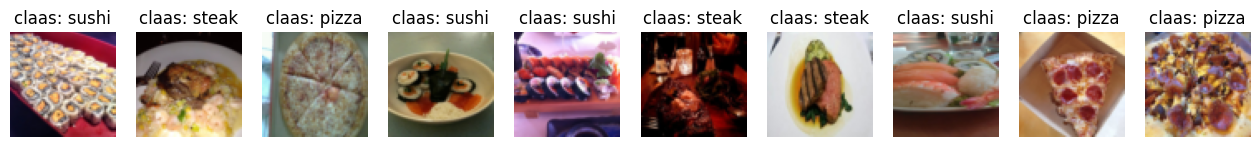

In [95]:
display_random_images(train_data_custom, classes[0] , n = 10, display_shape=False )


### Turn Custom loaded Image into DataLoader's

In [96]:
train_dataloader_custom = DataLoader(
    dataset = train_data_custom, 
    batch_size = 1, 
    num_workers= 0, 
    shuffle = True
    
)

train_dataloader_custom


## Data Augumentaion - Other forms of transforms 

The Purpose of transform is to alter our image in some way - that may be turning our image into tensor or cropping it 
or randomly erasing a portion or randomly rotating them 

Doing these kinds of transform is often referred to as data augumentation 

Data Augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training data

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization 


`TrivialAugment` : You have a set of transform and you randomly pick a number of them to perform on an image 
and at a random magnitude between a given range (higher magnitude means more intense).


`transforms.TrivialAugmentWide()` : parameter to pay attention `num_magnitute_bins=31` 

It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being lowest and 31 being higgest

In [98]:
train_trnasform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])




In [101]:
plot_transformed_images(image_path= image_path_list,
                        transforms= train_trnasfomr,
                        n = 3, seed=None
                        )


NameError: name 'train_trnasfomr' is not defined